In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt


In [8]:
# Download historical price data from Yahoo Finance
ticker = "NVDA"
start_date = "2019-01-01"
end_date = "2024-12-01"
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [9]:
# Save the data to a CSV file
output_path = "../data/NVDA.csv"
data.to_csv(output_path)

print(f"Data saved to {output_path}")


Data saved to ../data/NVDA.csv


Price      Adj Close    Close     High      Low     Open     Volume
Ticker          NVDA     NVDA     NVDA     NVDA     NVDA       NVDA
Date                                                               
2019-01-02  3.378090  3.40550  3.46200  3.25125  3.26600  508752000
2019-01-03  3.173996  3.19975  3.37900  3.19225  3.34475  705552000
2019-01-04  3.377346  3.40475  3.44325  3.24250  3.27350  585620000
2019-01-07  3.556145  3.58500  3.62225  3.41075  3.46250  709160000
2019-01-08  3.467614  3.49575  3.66950  3.42250  3.66725  786016000
Price      Ticker
Adj Close  NVDA      0
Close      NVDA      0
High       NVDA      0
Low        NVDA      0
Open       NVDA      0
Volume     NVDA      0
dtype: int64


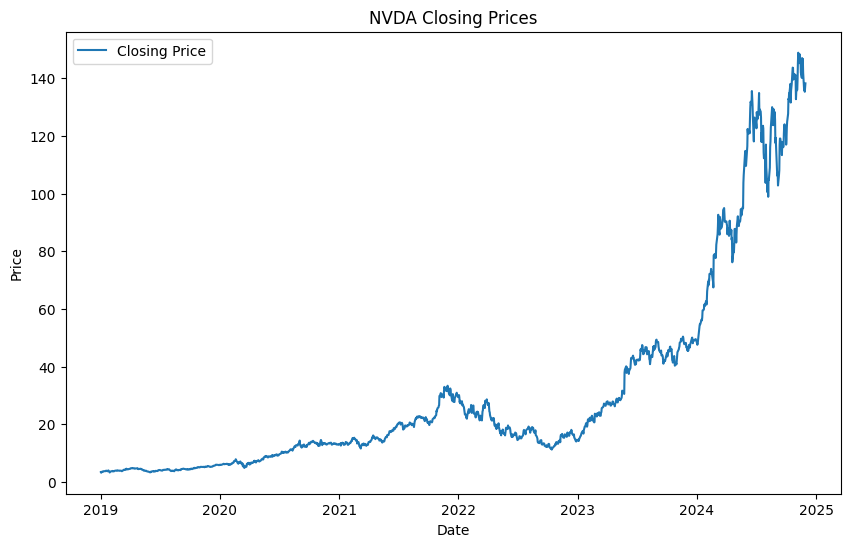

In [65]:
# input_path = "../data/NVDA.csv"
# data = pd.read_csv(input_path, index_col=0)

# Display the first few rows
print(data.head())

# Check for missing values
print(data.isnull().sum())


plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label="Closing Price")
plt.title(f"{ticker} Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [16]:
# Use only the 'Close' prices
close_prices = data['Close'].values

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))

# Create sequences for LSTM (e.g., look back 60 days to predict the next day)
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 60
X, y = create_sequences(scaled_data, look_back=look_back)

# Split into training and validation sets
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")


Training data shape: (1143, 60, 1), (1143, 1)
Validation data shape: (286, 60, 1), (286, 1)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5813e-04 - val_loss: 0.0037
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3476e-04 - val_loss: 0.0025
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2883e-04 - val_loss: 0.0022
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1962e-04 - val_loss: 0.0022
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1335e-04 - val_loss: 0.0034
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.8327e-05 - val_loss: 0.0020
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.8987e-05 - val_loss: 0.0028
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.1592e-05 - val_loss: 0.0022
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0461e-04 - val_loss: 0.0042
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.8566e-05 - val_loss: 0.0023
Epoch 12/100

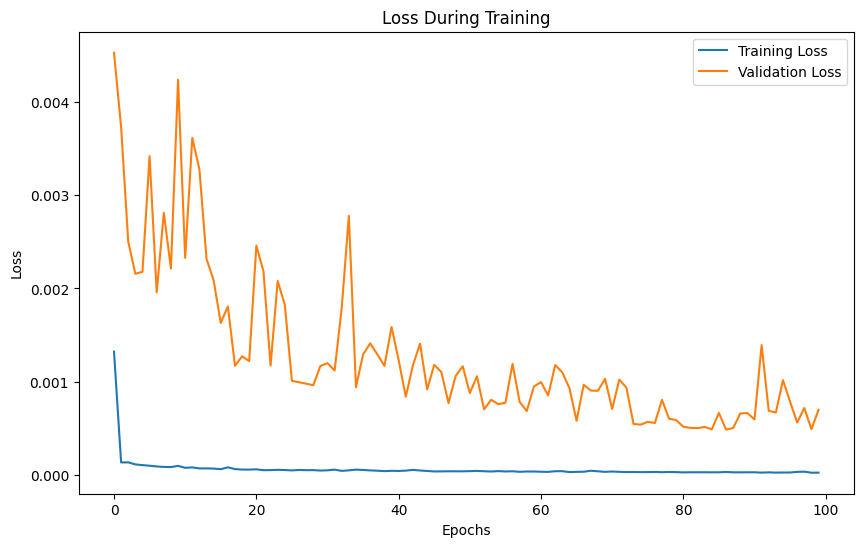

In [19]:
# Build the LSTM model
model = Sequential([
    Input(shape=(look_back, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


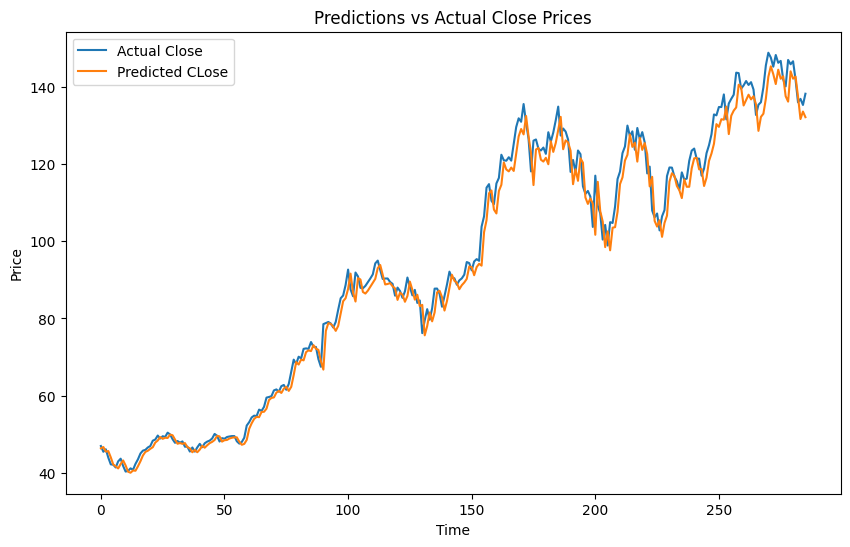

In [21]:
# Predict on the validation set
predictions = model.predict(X_val)

# Inverse transform predictions to the original scale
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_val)

# Plot actual vs predicted prices for each target
plt.figure(figsize=(10, 6))

plt.plot(actual_prices, label=f"Actual Close")
plt.plot(predicted_prices, label=f"Predicted CLose")
plt.title(f"Predictions vs Actual Close Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [66]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
features = data[['Open', 'High', 'Low', 'Close']].values  # Extract relevant columns
scaled_features = scaler.fit_transform(features)  # Normalize the features

# Now `scaled_features` is defined
print(scaled_features.shape)  # Check the shape to ensure correctness

# Use all price columns as targets
def create_sequences_multitarget(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])  # Sequence of `look_back` days
        y.append(data[i])             # Predict all columns (Open, High, Low, Close)
    return np.array(X), np.array(y)

look_back = 60
X, y = create_sequences_multitarget(scaled_features, look_back=look_back)

# Split into training and validation sets
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")


(1489, 4)
Training data shape: (1143, 60, 4), (1143, 4)
Validation data shape: (286, 60, 4), (286, 4)


In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger,  ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# Build the multi-target Bidirectional LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(LSTM(50, activation='relu', return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(50, activation='relu')),
    Dropout(0.2),
    Dense(4)  # Output 4 values (Open, High, Low, Close)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [68]:
# Callbacks
checkpoint = ModelCheckpoint(
    filepath='best_lstm_multitarget2.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
csv_logger = CSVLogger('training_log_multitarget2.csv', append=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=[checkpoint, early_stopping, csv_logger, reduce_lr],
    verbose=1
)


Epoch 1/500
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0049
Epoch 1: val_loss improved from inf to 0.00766, saving model to best_lstm_multitarget2.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0048 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.3608e-04
Epoch 2: val_loss improved from 0.00766 to 0.00106, saving model to best_lstm_multitarget2.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.3148e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 3/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.4763e-04
Epoch 3: val_loss improved from 0.00106 to 0.00049, saving model to best_lstm_multitarget2.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.4696e-04 - val_loss: 4.9187e-04 - learning_rate: 0.0010
Epoch 4/500
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.7168e-04
Epoch 4: val_loss did not improve from 0.00049
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.7116e-04 - val_loss: 5.5485e-0

In [69]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f'Train Loss: {train_loss:.6f}')
print(f'Test Loss: {val_loss:.6f}')

# Predict Open, High, Low, Close prices
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)


Train Loss: 0.000061
Test Loss: 0.049961
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Predictions shape: (286, 4)
Actual values shape: (286, 4)


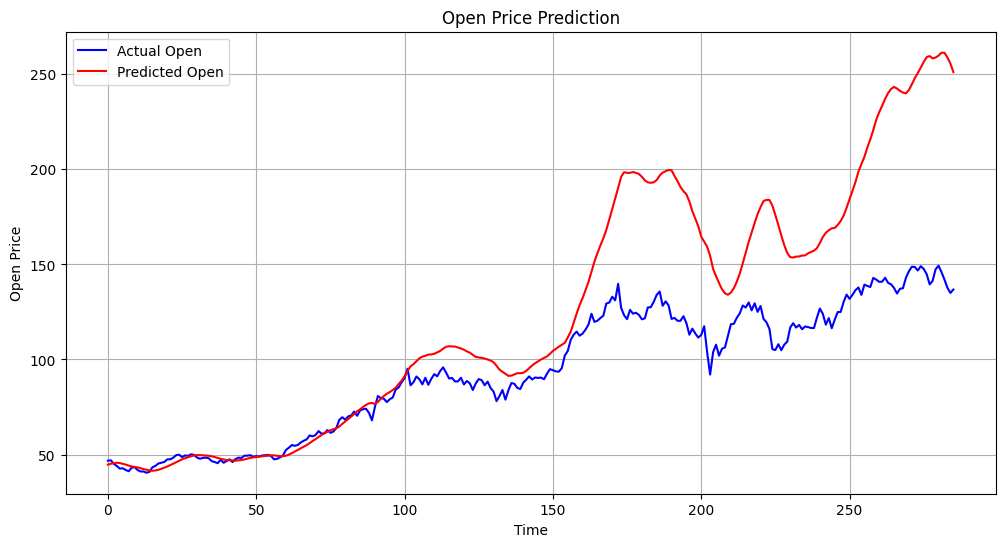

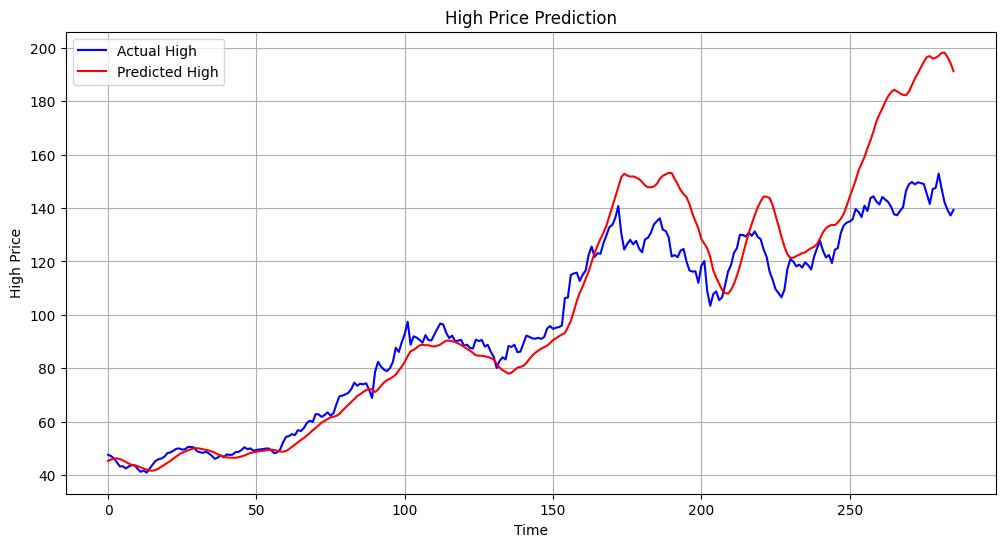

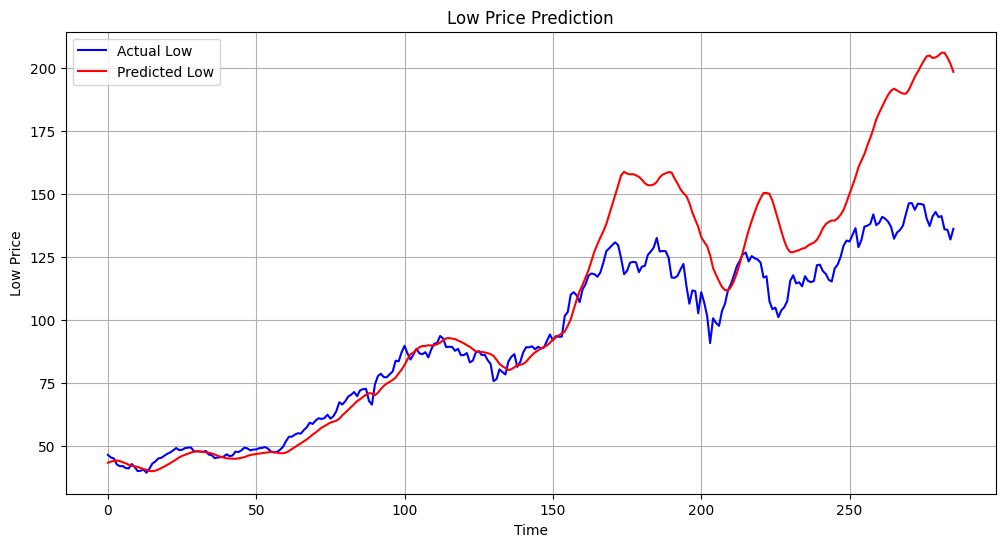

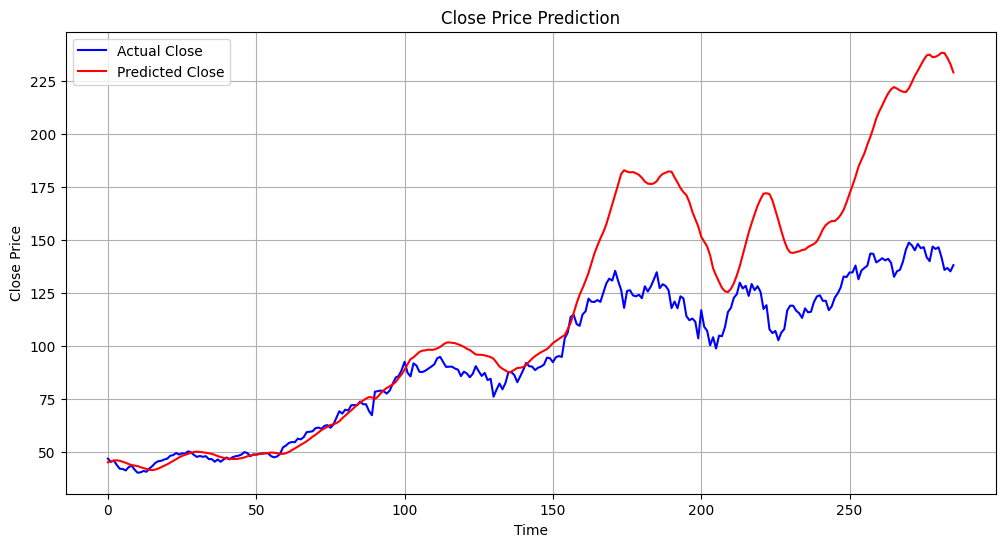

In [71]:
# Predict on validation set
predictions = model.predict(X_val)

# Denormalize predictions and actual values
predictions_denormalized = scaler.inverse_transform(predictions)
y_val_denormalized = scaler.inverse_transform(y_val)

# Print shapes for debugging
print(f"Predictions shape: {predictions_denormalized.shape}")
print(f"Actual values shape: {y_val_denormalized.shape}")


import matplotlib.pyplot as plt

# Define target column names
columns = ['Open', 'High', 'Low', 'Close']

# Plot predictions vs actual values for each target
for i, column in enumerate(columns):
    plt.figure(figsize=(12, 6))
    plt.plot(y_val_denormalized[:, i], label=f'Actual {column}', color='blue')
    plt.plot(predictions_denormalized[:, i], label=f'Predicted {column}', color='red')
    plt.title(f'{column} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{column} Price')
    plt.legend()
    plt.grid(True)
    plt.show()



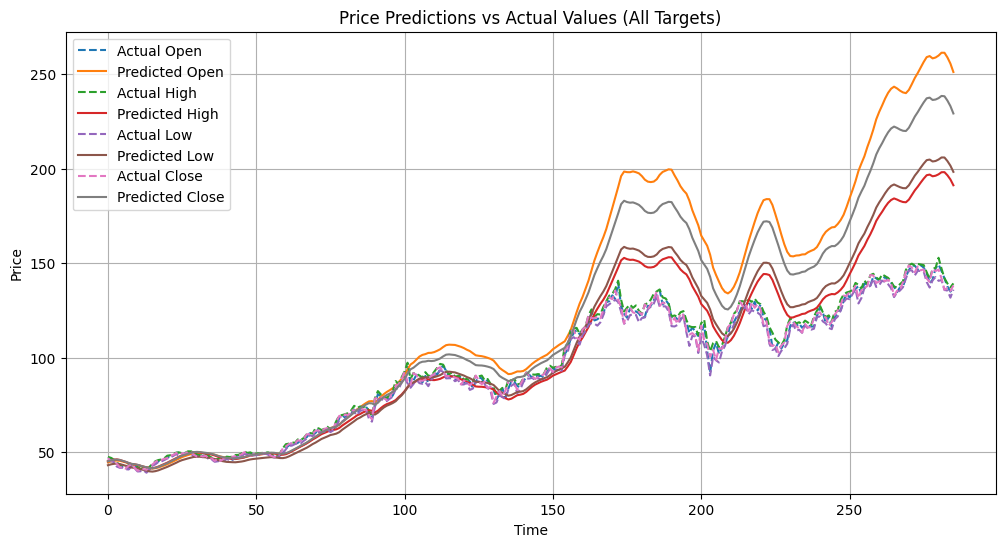

In [72]:
plt.figure(figsize=(12, 6))
for i, column in enumerate(columns):
    plt.plot(y_val_denormalized[:, i], label=f'Actual {column}', linestyle='--')
    plt.plot(predictions_denormalized[:, i], label=f'Predicted {column}')
plt.title('Price Predictions vs Actual Values (All Targets)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [73]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(LSTM(50, activation='tanh', return_sequences=True)),
    Dropout(0.3),  
    Bidirectional(LSTM(50, activation='tanh')),
    Dropout(0.3),  
    Dense(4)  
])

# Callbacks
checkpoint = ModelCheckpoint(
    filepath='best_lstm_multitarget3.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
csv_logger = CSVLogger('training_log_multitarget.csv', append=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

look_back = 60
X, y = create_sequences_multitarget(scaled_features, look_back=look_back)

model.compile(optimizer='adam', loss=Huber(delta=1.0))

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,  
    batch_size=32,  
    callbacks=[checkpoint, early_stopping, csv_logger, reduce_lr],
    verbose=1
)




Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.9090e-04
Epoch 1: val_loss improved from inf to 0.00074, saving model to best_lstm_multitarget3.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9.7597e-04 - val_loss: 7.4390e-04 - learning_rate: 0.0010
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8165e-04
Epoch 2: val_loss improved from 0.00074 to 0.00041, saving model to best_lstm_multitarget3.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.8100e-04 - val_loss: 4.0966e-04 - learning_rate: 0.0010
Epoch 3/200
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3169e-04
Epoch 3: val_loss improved from 0.00041 to 0.00033, saving model to best_lstm_multitarget3.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.3117e-04 - val_loss: 3.2503e-04 - learning_rate: 0.0010
Epoch 4/200
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1423e-04
Epoch 4: val_loss improved from 0.00033 to 0.00026, saving model to best_lstm_multitarget3.keras
29/29 ━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predictions shape: (286, 4)
Actual values shape: (286, 4)


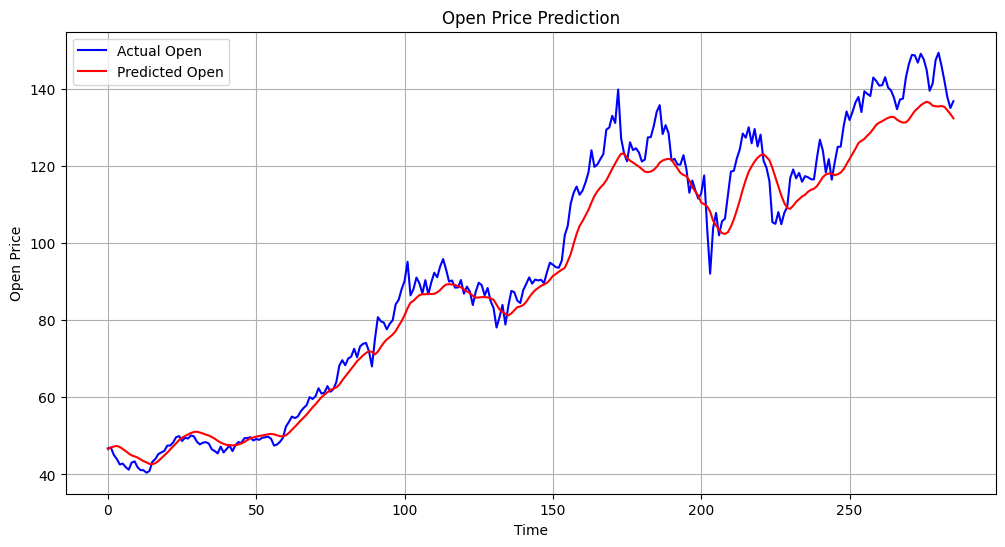

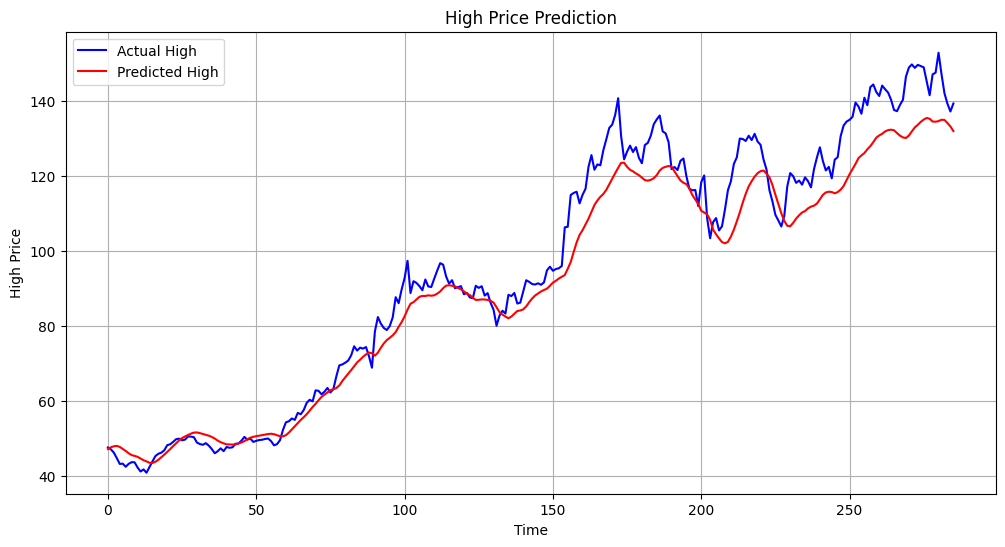

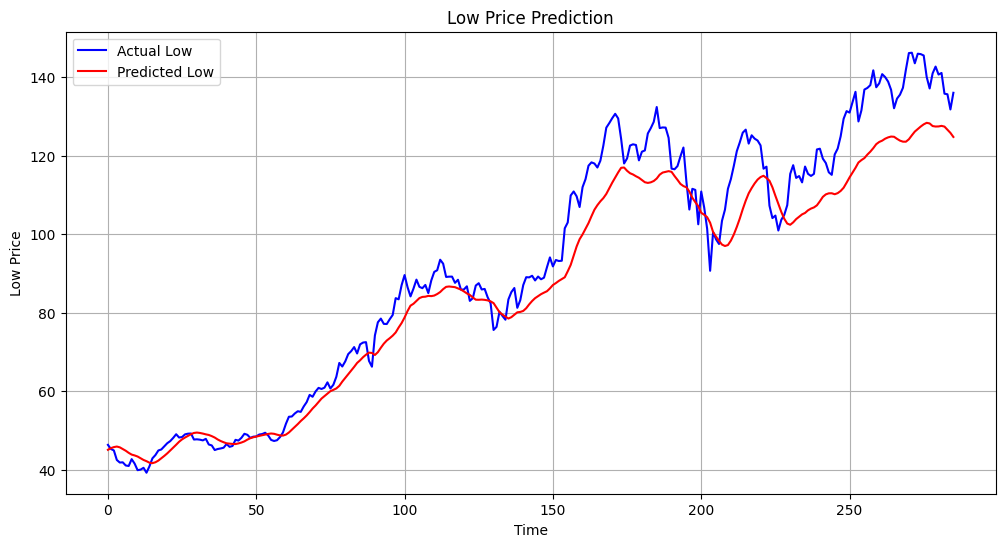

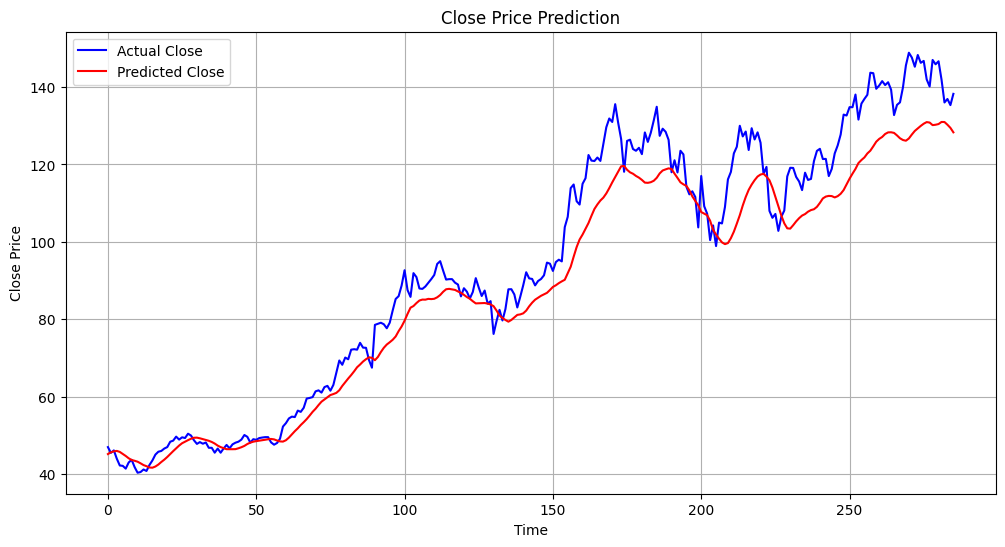

In [74]:
# Predict on validation set
predictions = model.predict(X_val)

# Denormalize the predictions and actual values
predictions_denormalized = scaler.inverse_transform(predictions)
y_val_denormalized = scaler.inverse_transform(y_val)

# Print shapes for debugging
print(f"Predictions shape: {predictions_denormalized.shape}")
print(f"Actual values shape: {y_val_denormalized.shape}")

# Define target column names
columns = ['Open', 'High', 'Low', 'Close']

# Plot predictions vs actual values for each target
for i, column in enumerate(columns):
    plt.figure(figsize=(12, 6))
    plt.plot(y_val_denormalized[:, i], label=f'Actual {column}', color='blue')
    plt.plot(predictions_denormalized[:, i], label=f'Predicted {column}', color='red')
    plt.title(f'{column} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{column} Price')
    plt.legend()
    plt.grid(True)
    plt.show()



Narrow input sequencial dataset

In [46]:
# Define the split ratio
train_ratio = 0.7
train_size = int(len(features) * train_ratio)

# Use older data for training and recent data for validation
train_data = features[:train_size]
validation_data = features[train_size:]

print(f"Training data range: {len(train_data)} rows")
print(f"Validation data range: {len(validation_data)} rows")


Training data range: 1042 rows
Validation data range: 447 rows


In [47]:
def create_recent_sequences(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])  # Input sequence of `look_back` days
        y.append(data[i + look_back, :4])  # Predict Open, High, Low, Close (first 4 columns)
    return np.array(X), np.array(y)

# Create sequences for training and validation
look_back = 60
X_train, y_train = create_recent_sequences(train_data, look_back)
X_val, y_val = create_recent_sequences(validation_data, look_back)

print(f"Training input shape: {X_train.shape}, Training target shape: {y_train.shape}")
print(f"Validation input shape: {X_val.shape}, Validation target shape: {y_val.shape}")


Training input shape: (982, 60, 4), Training target shape: (982, 4)
Validation input shape: (387, 60, 4), Validation target shape: (387, 4)
